# Implementing Q-Learning Algorithm


All the setup is the same as basic sarsa, except the Q-value update equation is different. 

## 1. Set up libararies and imports


In [1]:
import sys
import os

# Add META-RL-SNAKE (project root) to path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from meta_snake_rl.env.snake_env import SnakeEnv, select_action, get_state
from meta_snake_rl.utils.constants import ACTIONS, OPPOSITE

## 2. Q-Learning Hyperparameter Setup (Same as TD(0))


In [3]:
# Q-Table
Q = {}

# Training hyperparameters
alpha, gamma, epsilon, min_epsilon, decay_rate, episodes = 0.1, 0.95, 1.0, 0.01, 0.9985, 5000

# Metrics logging
#episode_rewards = []


## 3. Environment Initializations


In [4]:
q_learning_env = SnakeEnv(grid_size=15, variant="classic")

## 4. Q-Learning Training Loop


In [5]:
def q_learning_loop(alpha, gamma, epsilon, min_epsilon, decay_rate, episodes, episode_rewards):
    unique_states_seen = []
    total_apples_eaten = []
    for episode in range(episodes):
        total_reward = 0
        total_apples = 0
        q_learning_env.reset()
        state = get_state(q_learning_env.snake, q_learning_env.apple, q_learning_env.direction, q_learning_env.grid_size)
        direction = q_learning_env.direction
        done = False

        while not done:
            action = select_action(Q, state, epsilon, direction)
            _, reward, done, _ = q_learning_env.step(action)
            if reward == 10:
                total_apples += 1
            next_state = get_state(q_learning_env.snake, q_learning_env.apple, q_learning_env.direction, q_learning_env.grid_size)
            next_direction = q_learning_env.direction

            if state not in Q:
                Q[state] = {a: 0 for a in ACTIONS}
            if next_state not in Q:
                Q[next_state] = {a: 0 for a in ACTIONS}
            
            # SARSA update
            old_q = Q[state][action]
            max_next_q = max(Q[next_state].values())
            
            # This is the main difference! We are grabbing the maximum Q possible instead. 
            Q[state][action] += alpha * (reward + gamma * max_next_q - old_q)

            # Move to next
            state = next_state
            direction = next_direction
            total_reward += reward

        episode_rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)
        # total_apples_eaten.append(total_apples)
        # print("Total apples is ", total_apples)

        # if episode % 50 == 0:
        #     print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")
        # unique_states_seen.append(len(Q))

        # if episode % 100 == 0:
        #     print(f"Episode {episode} — Unique states so far: {len(Q)}")
    # print(max(total_apples_eaten))
    return episode_rewards, total_apples_eaten

### Code for MatPlotLib Display

In [6]:
def plot_rewards_progress(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("SARSA Training Progress")
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
def plot_apples_progress(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Apples Eaten')
    plt.xlabel("Episode")
    plt.ylabel("Total Apples")
    plt.title("SARSA Training Progress - Apples Eaten")
    plt.grid(True)
    plt.legend()
    plt.show()

# 5. Applying Hyperparameter Optimization Techniques!

## 5a. Random Search 

In [9]:
import random 
from tqdm.notebook import tqdm

ALPHA_RANGE = (0.1, 0.4)
GAMMA_RANGE = (0.9, 0.99)
DECAY_RANGE = (0.995, 0.9995)

N_TRIALS = 50
EPISODES = 10000
TOP_N = 5

results = []

for _ in tqdm(range(N_TRIALS), desc = "Random Search"):
    alpha = round(random.uniform(*ALPHA_RANGE), 3)
    gamma = round(random.uniform(*GAMMA_RANGE), 3)
    decay = round(random.uniform(*DECAY_RANGE), 5)

    # Reset Q-table
    Q = {}

    episode_rewards = []
    q_learning_env.reset()
    q_learning_loop(
        alpha=alpha,
        gamma=gamma,
        epsilon=1.0, 
        min_epsilon=0.01,
        decay_rate=decay,
        episodes=EPISODES,
        episode_rewards=episode_rewards
    )

    # Calculate moving average for reward for the last 100 episodes
    avg_reward = sum(episode_rewards[-100:]) / 100
    results.append((avg_reward, alpha, gamma, decay))
    print(f"[{len(results)}/{N_TRIALS}] α={alpha}, γ={gamma}, decay={decay} → avg_reward={avg_reward:.2f}")

# Sort it based on avg_reward
results.sort(reverse=True)
print("\n Top configs:")
for avg, a, g, d in results[:TOP_N]:
    print(f"α={a}, γ={g}, decay={d} → avg_reward={avg:.2f}")


Random Search:   0%|          | 0/50 [00:00<?, ?it/s]

[1/50] α=0.291, γ=0.934, decay=0.99581 → avg_reward=10.85
[2/50] α=0.38, γ=0.975, decay=0.99501 → avg_reward=6.58
[3/50] α=0.193, γ=0.948, decay=0.99621 → avg_reward=13.55
[4/50] α=0.304, γ=0.947, decay=0.99771 → avg_reward=6.36
[5/50] α=0.171, γ=0.934, decay=0.99673 → avg_reward=11.97
[6/50] α=0.14, γ=0.951, decay=0.99568 → avg_reward=13.17
[7/50] α=0.202, γ=0.951, decay=0.99864 → avg_reward=10.61
[8/50] α=0.28, γ=0.932, decay=0.99635 → avg_reward=10.04
[9/50] α=0.257, γ=0.931, decay=0.99791 → avg_reward=11.24
[10/50] α=0.343, γ=0.985, decay=0.99936 → avg_reward=11.78
[11/50] α=0.308, γ=0.951, decay=0.9993 → avg_reward=9.02
[12/50] α=0.162, γ=0.904, decay=0.99743 → avg_reward=13.22
[13/50] α=0.202, γ=0.961, decay=0.99703 → avg_reward=10.74
[14/50] α=0.213, γ=0.946, decay=0.99656 → avg_reward=12.72
[15/50] α=0.181, γ=0.931, decay=0.99647 → avg_reward=12.77
[16/50] α=0.239, γ=0.908, decay=0.99691 → avg_reward=9.64
[17/50] α=0.314, γ=0.966, decay=0.99769 → avg_reward=9.12
[18/50] α=0.237

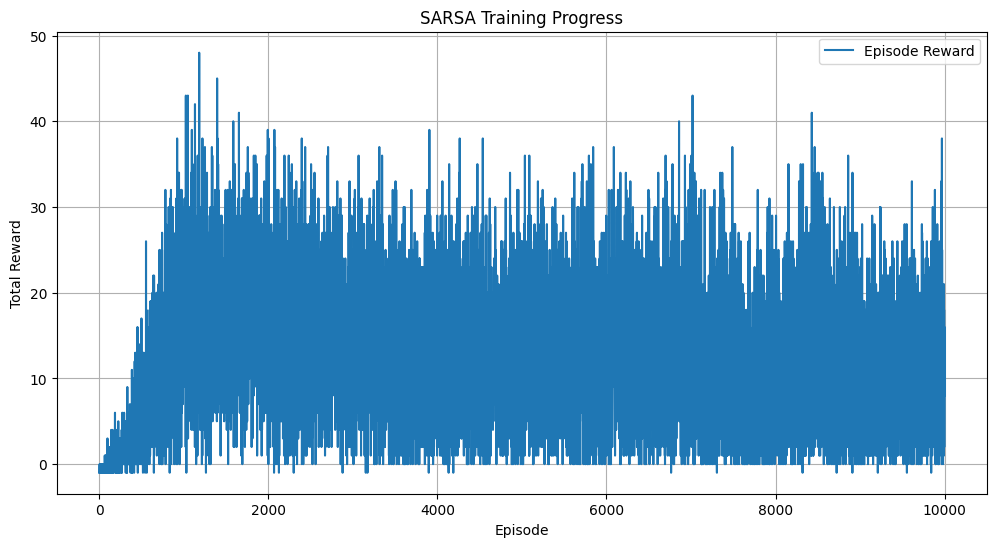

In [11]:
Q = {}
alpha, gamma, epsilon, min_epsilon, decay_rate, episodes = 0.237, 0.915, 1.0, 0.01, 0.99552, 10000
episode_rewards_best = []
episode_rewards_best, _ = q_learning_loop(alpha, gamma, epsilon, min_epsilon, decay_rate, episodes, episode_rewards_best)
plot_rewards_progress(episode_rewards_best)

### Visualize Random Search results

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial: ")
print(f" Value: {study.best_value:.2f}")
print(f" Params: {study.best_params}")

best_alpha, best_gamma, best_decay_rate = study.best_params.values()
print(best_alpha, best_gamma, best_decay_rate)
study.trials_dataframe()

[I 2025-06-02 01:19:16,954] A new study created in memory with name: no-name-722fd605-a6ac-4fa8-92e6-f94f16cbb951
[I 2025-06-02 01:19:24,724] Trial 0 finished with value: 15.8 and parameters: {'alpha': 0.1916287135128933, 'gamma': 0.9496006695908521, 'decay_rate': 0.9985949830878699}. Best is trial 0 with value: 15.8.
[I 2025-06-02 01:19:33,137] Trial 1 finished with value: 16.53 and parameters: {'alpha': 0.15491706938196875, 'gamma': 0.9581448615068303, 'decay_rate': 0.9974831269877136}. Best is trial 1 with value: 16.53.
[I 2025-06-02 01:19:40,976] Trial 2 finished with value: 7.28 and parameters: {'alpha': 0.27586010145595685, 'gamma': 0.9208260485063257, 'decay_rate': 0.9966491228847755}. Best is trial 1 with value: 16.53.
[I 2025-06-02 01:19:48,437] Trial 3 finished with value: 7.54 and parameters: {'alpha': 0.25535956973195195, 'gamma': 0.9515834262670608, 'decay_rate': 0.9973954586924076}. Best is trial 1 with value: 16.53.
[I 2025-06-02 01:19:57,376] Trial 4 finished with value

Best trial: 
 Value: 16.53
 Params: {'alpha': 0.15491706938196875, 'gamma': 0.9581448615068303, 'decay_rate': 0.9974831269877136}
0.15491706938196875 0.9581448615068303 0.9974831269877136


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_decay_rate,params_gamma,state
0,0,15.80,2025-06-02 01:19:16.956158,2025-06-02 01:19:24.724868,0 days 00:00:07.768710,0.191629,0.998595,0.949601,COMPLETE
1,1,16.53,2025-06-02 01:19:24.725867,2025-06-02 01:19:33.137640,0 days 00:00:08.411773,0.154917,0.997483,0.958145,COMPLETE
2,2,7.28,2025-06-02 01:19:33.138640,2025-06-02 01:19:40.976144,0 days 00:00:07.837504,0.275860,0.996649,0.920826,COMPLETE
3,3,7.54,2025-06-02 01:19:40.977145,2025-06-02 01:19:48.437835,0 days 00:00:07.460690,0.255360,0.997395,0.951583,COMPLETE
4,4,11.78,2025-06-02 01:19:48.438833,2025-06-02 01:19:57.375603,0 days 00:00:08.936770,0.103560,0.995603,0.925603,COMPLETE
5,5,9.07,2025-06-02 01:19:57.376587,2025-06-02 01:20:04.773661,0 days 00:00:07.397074,0.325188,0.996750,0.949250,COMPLETE
6,6,11.50,2025-06-02 01:20:04.774669,2025-06-02 01:20:12.466419,0 days 00:00:07.691750,0.154522,0.997490,0.959634,COMPLETE
7,7,9.46,2025-06-02 01:20:12.467411,2025-06-02 01:20:17.598390,0 days 00:00:05.130979,0.223175,0.999049,0.968233,COMPLETE
8,8,6.30,2025-06-02 01:20:17.600404,2025-06-02 01:20:26.021863,0 days 00:00:08.421459,0.307657,0.996538,0.976232,COMPLETE
9,9,8.05,2025-06-02 01:20:26.022915,2025-06-02 01:20:30.312928,0 days 00:00:04.290013,0.370549,0.999131,0.957255,COMPLETE


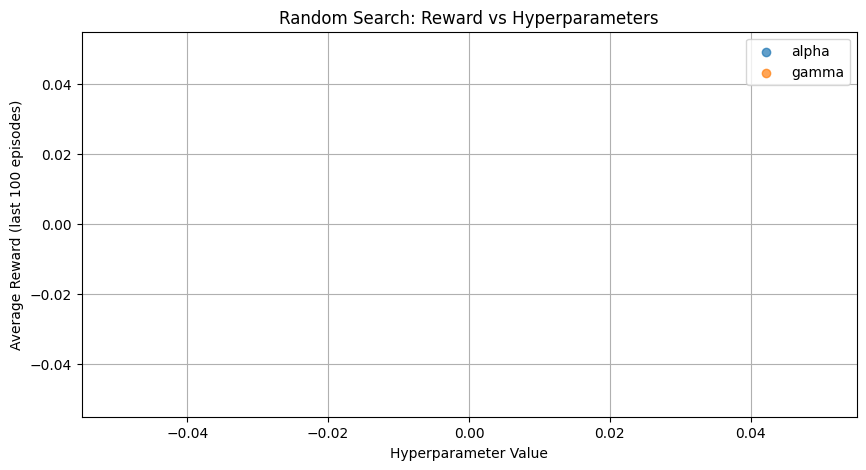

In [ ]:
alphas = [a for _, a, _, _ in results]
gammas = [g for _, _, g, _ in results]
avg_rewards = [r for r, _, _, _ in results]

plt.figure(figsize=(10, 5))
plt.scatter(alphas, avg_rewards, label="alpha", alpha=0.7)
plt.scatter(gammas, avg_rewards, label="gamma", alpha=0.7)
plt.xlabel("Hyperparameter Value")
plt.ylabel("Average Reward (last 100 episodes)")
plt.title("Random Search: Reward vs Hyperparameters")
plt.legend()
plt.grid(True)
plt.show()


## 5b. Bayesian (Optuna Wrapper)

### Set up Optuna Objective Function

In [ ]:
import optuna 
def objective(trial):
# Let Optuna suggest values within ranges
    alpha = trial.suggest_float("alpha", 0.1, 0.4)
    gamma = trial.suggest_float("gamma", 0.9, 0.99)
    decay_rate = trial.suggest_float("decay_rate", 0.995, 0.9995)

    # Set fixed training params
    episodes = 5000
    min_epsilon = 0.01
    epsilon = 1.0

    # Clear and initialize Q-table
    Q = {}

    # Run training
    episode_rewards = []
    q_learning_env.reset()
    q_learning_loop(
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        min_epsilon=min_epsilon,
        decay_rate=decay_rate,
        episodes=episodes,
        episode_rewards=episode_rewards,
    )

    # Compute score: average of last 100 episode rewards
    avg_reward = sum(episode_rewards[-100:]) / 100
    return avg_reward

### Create trials for Optuna

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial: ")
print(f" Value: {study.best_value:.2f}")
print(f" Params: {study.best_params}")

best_alpha, best_gamma, best_decay_rate = study.best_params.values()
print(best_alpha, best_gamma, best_decay_rate)
study.trials_dataframe()

[I 2025-06-02 01:19:16,954] A new study created in memory with name: no-name-722fd605-a6ac-4fa8-92e6-f94f16cbb951
[I 2025-06-02 01:19:24,724] Trial 0 finished with value: 15.8 and parameters: {'alpha': 0.1916287135128933, 'gamma': 0.9496006695908521, 'decay_rate': 0.9985949830878699}. Best is trial 0 with value: 15.8.
[I 2025-06-02 01:19:33,137] Trial 1 finished with value: 16.53 and parameters: {'alpha': 0.15491706938196875, 'gamma': 0.9581448615068303, 'decay_rate': 0.9974831269877136}. Best is trial 1 with value: 16.53.
[I 2025-06-02 01:19:40,976] Trial 2 finished with value: 7.28 and parameters: {'alpha': 0.27586010145595685, 'gamma': 0.9208260485063257, 'decay_rate': 0.9966491228847755}. Best is trial 1 with value: 16.53.
[I 2025-06-02 01:19:48,437] Trial 3 finished with value: 7.54 and parameters: {'alpha': 0.25535956973195195, 'gamma': 0.9515834262670608, 'decay_rate': 0.9973954586924076}. Best is trial 1 with value: 16.53.
[I 2025-06-02 01:19:57,376] Trial 4 finished with value

Best trial: 
 Value: 16.53
 Params: {'alpha': 0.15491706938196875, 'gamma': 0.9581448615068303, 'decay_rate': 0.9974831269877136}
0.15491706938196875 0.9581448615068303 0.9974831269877136


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_decay_rate,params_gamma,state
0,0,15.80,2025-06-02 01:19:16.956158,2025-06-02 01:19:24.724868,0 days 00:00:07.768710,0.191629,0.998595,0.949601,COMPLETE
1,1,16.53,2025-06-02 01:19:24.725867,2025-06-02 01:19:33.137640,0 days 00:00:08.411773,0.154917,0.997483,0.958145,COMPLETE
2,2,7.28,2025-06-02 01:19:33.138640,2025-06-02 01:19:40.976144,0 days 00:00:07.837504,0.275860,0.996649,0.920826,COMPLETE
3,3,7.54,2025-06-02 01:19:40.977145,2025-06-02 01:19:48.437835,0 days 00:00:07.460690,0.255360,0.997395,0.951583,COMPLETE
4,4,11.78,2025-06-02 01:19:48.438833,2025-06-02 01:19:57.375603,0 days 00:00:08.936770,0.103560,0.995603,0.925603,COMPLETE
5,5,9.07,2025-06-02 01:19:57.376587,2025-06-02 01:20:04.773661,0 days 00:00:07.397074,0.325188,0.996750,0.949250,COMPLETE
6,6,11.50,2025-06-02 01:20:04.774669,2025-06-02 01:20:12.466419,0 days 00:00:07.691750,0.154522,0.997490,0.959634,COMPLETE
7,7,9.46,2025-06-02 01:20:12.467411,2025-06-02 01:20:17.598390,0 days 00:00:05.130979,0.223175,0.999049,0.968233,COMPLETE
8,8,6.30,2025-06-02 01:20:17.600404,2025-06-02 01:20:26.021863,0 days 00:00:08.421459,0.307657,0.996538,0.976232,COMPLETE
9,9,8.05,2025-06-02 01:20:26.022915,2025-06-02 01:20:30.312928,0 days 00:00:04.290013,0.370549,0.999131,0.957255,COMPLETE


### Applying the supposed best strategy

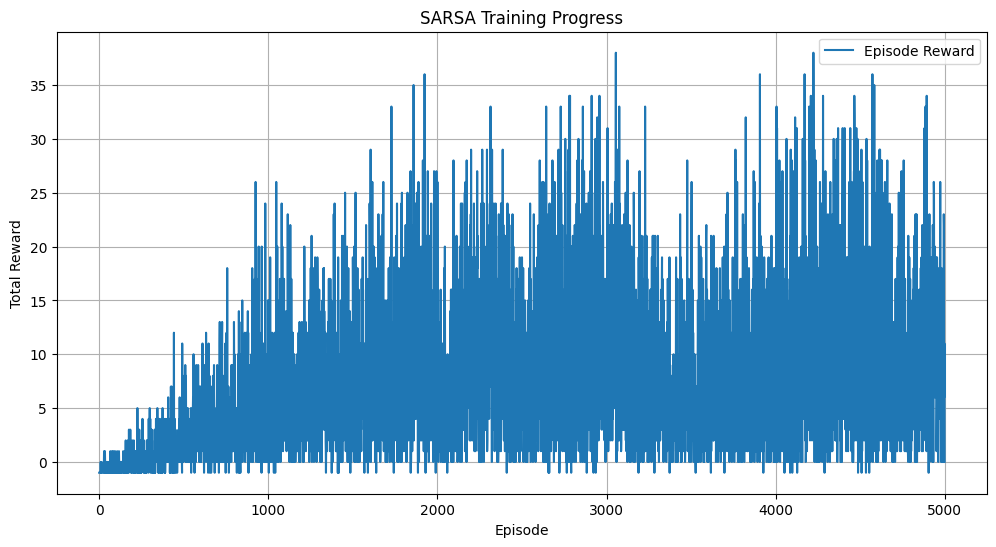

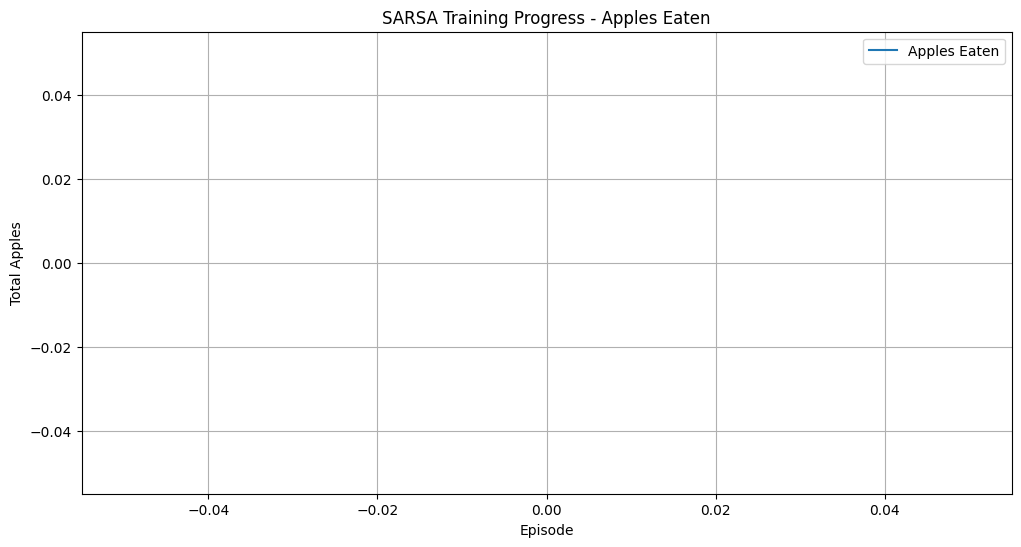

In [ ]:
q_episode_rewards = []
q_episode_rewards, q_apples = q_learning_loop(best_alpha, best_gamma, 1, 0.01, best_decay_rate, 5000, q_episode_rewards)
plot_rewards_progress(q_episode_rewards)
plot_apples_progress(q_apples)


### Optuna Visualizations

In [ ]:
import optuna.visualization as vis

vis.plot_optimization_history(study)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial: ")
print(f" Value: {study.best_value:.2f}")
print(f" Params: {study.best_params}")

best_alpha, best_gamma, best_decay_rate = study.best_params.values()
print(best_alpha, best_gamma, best_decay_rate)
study.trials_dataframe()

[I 2025-06-02 00:56:10,587] A new study created in memory with name: no-name-ff679bbd-eba4-4aaa-8f72-bcb50fe1a742
[I 2025-06-02 00:56:13,996] Trial 0 finished with value: 7.9 and parameters: {'alpha': 0.3931188715699373, 'gamma': 0.9315113041501262, 'decay_rate': 0.9950731741123201}. Best is trial 0 with value: 7.9.
[I 2025-06-02 00:56:17,920] Trial 1 finished with value: 8.47 and parameters: {'alpha': 0.1552943499368619, 'gamma': 0.9677418795646346, 'decay_rate': 0.9962513444366812}. Best is trial 1 with value: 8.47.
[I 2025-06-02 00:56:20,569] Trial 2 finished with value: 3.77 and parameters: {'alpha': 0.3707511927091087, 'gamma': 0.9075515166846586, 'decay_rate': 0.9974199624549386}. Best is trial 1 with value: 8.47.
[I 2025-06-02 00:56:24,050] Trial 3 finished with value: 6.32 and parameters: {'alpha': 0.2595303002643101, 'gamma': 0.9449866792141703, 'decay_rate': 0.996416194496974}. Best is trial 1 with value: 8.47.
[I 2025-06-02 00:56:25,129] Trial 4 finished with value: 2.36 and

Best trial: 
 Value: 12.84
 Params: {'alpha': 0.1002973929652267, 'gamma': 0.9547951188834307, 'decay_rate': 0.99656635469321}
0.1002973929652267 0.9547951188834307 0.99656635469321


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_decay_rate,params_gamma,state
0,0,7.90,2025-06-02 00:56:10.589927,2025-06-02 00:56:13.995950,0 days 00:00:03.406023,0.393119,0.995073,0.931511,COMPLETE
1,1,8.47,2025-06-02 00:56:13.996942,2025-06-02 00:56:17.920024,0 days 00:00:03.923082,0.155294,0.996251,0.967742,COMPLETE
2,2,3.77,2025-06-02 00:56:17.921493,2025-06-02 00:56:20.569554,0 days 00:00:02.648061,0.370751,0.997420,0.907552,COMPLETE
3,3,6.32,2025-06-02 00:56:20.570580,2025-06-02 00:56:24.050047,0 days 00:00:03.479467,0.259530,0.996416,0.944987,COMPLETE
4,4,2.36,2025-06-02 00:56:24.051564,2025-06-02 00:56:25.129500,0 days 00:00:01.077936,0.287003,0.999411,0.901242,COMPLETE
5,5,5.02,2025-06-02 00:56:25.130523,2025-06-02 00:56:27.637500,0 days 00:00:02.506977,0.275264,0.997524,0.982159,COMPLETE
6,6,7.42,2025-06-02 00:56:27.638509,2025-06-02 00:56:30.113465,0 days 00:00:02.474956,0.244162,0.997839,0.963311,COMPLETE
7,7,9.31,2025-06-02 00:56:30.114522,2025-06-02 00:56:32.619524,0 days 00:00:02.505002,0.128614,0.997913,0.909896,COMPLETE
8,8,3.85,2025-06-02 00:56:32.620521,2025-06-02 00:56:34.924611,0 days 00:00:02.304090,0.353593,0.997948,0.906390,COMPLETE
9,9,7.92,2025-06-02 00:56:34.925613,2025-06-02 00:56:38.216061,0 days 00:00:03.290448,0.155872,0.997081,0.986635,COMPLETE


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_contour(study, params=["alpha", "gamma"])

In [ ]:
vis.plot_parallel_coordinate(study)